REBOUND RV and Plotting function
====================================

In [1]:
import numpy as np
import numpy.random as rd
import os
import rebound
import matplotlib.pyplot as plt
%matplotlib inline 

days_p_year = 365.25

def rebound_rvs(times, Ps, ms, system="test", id_=0, es=0, Mstar=1):
    
    Nplanets = len(Ps)
    
    if es==0:
        es = np.zeros(Nplanets)
        
    assert Nplanets==len(ms)==len(es)
    assert np.all(np.diff(times)>=0), "times passed aren't sorted"
    
    
    name = "%s_%d"%(system,id_)

    earth_mass_2_solar_mass = 0.000003003
    radii = np.zeros(Nplanets)
    for i in range(Nplanets):
        radii[i] = (1 - es[i]) * np.cbrt(Ps[i] * Ps[i] * ms[i] * earth_mass_2_solar_mass / Mstar / 3) / 2

    #set up simulation
    sim = rebound.Simulation()

    sim.collision = 'line'

    #add star
    sim.add(m=Mstar)
    # sim.add(m=Ms, r=radii[0]*10**(-3))

    year_p_reboundtime = 1 / (2 * np.pi)
    seconds_p_day = 86400

    a = np.cbrt(Ps * Ps)
    Rs2AU = 0.00465047
    Rstar = 1
    incs=np.array([rd.uniform(high=0.9 * Rstar * Rs2AU / a[i]) for i in range(Nplanets)])
    Ws=2 * np.pi * rd.sample(Nplanets)
    ws=2 * np.pi * rd.sample(Nplanets)
    Ms=2 * np.pi * rd.sample(Nplanets)
    for i in range(Nplanets):
        m = ms[i] * earth_mass_2_solar_mass
        P = Ps[i]
        e = es[i]
        inc = incs[i]
        W = Ws[i]
        w = ws[i]
        M = Ms[i]
        sim.add(m=m, P=P / year_p_reboundtime, e=e, inc=inc, Omega=W, omega=w, M=M, r=radii[i]) #G=1 units!
    sim.move_to_com()
    
    times_rb = times / year_p_reboundtime
    
    #save simulation archive
    # dir_path = os.path.dirname(os.path.realpath(__file__)) #directory of this program
    dir_path = os.getcwd()
    out_dir = dir_path + "/output/"
    os.system('mkdir %s'%out_dir)
    out_dir=out_dir + "%s/"%system
    os.system('mkdir %s'%out_dir)

    sim.automateSimulationArchive(out_dir + '%s_SA.bin'%name, interval=times_rb[-1] / 1000, deletefile=True) #save checkpoints.
    meters_p_AU = 149597870700

    rvs = np.zeros(len(times))
    for i in range(len(times)):
        sim.integrate(times_rb[i])
        rvs[i] = sim.particles[0].vx
    rvs = rvs * meters_p_AU / year_p_reboundtime / days_p_year / seconds_p_day
    return rvs

# Convenient function for plotting fits
def plot_results(like):
    ti = np.linspace(np.min(t), np.max(t), 1000)
    fig = plt.gcf()
    plt.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plt.plot(ti, like.model(ti))
    plt.xlabel('Time')
    plt.ylabel('RV')
    plt.draw()

Getting RVs
====================================

In [2]:
# Ps = np.array([1, 2, 4]) # years
# # es = np.array([0, 0, 0])
# ms = np.array([10, 10, 10])  # earth masses
Ps = np.array([1]) # years
ms = np.array([10])  # earth masses
n_meas = 400
t = 10 * np.sort(rd.rand(n_meas))
syn_rv = rebound_rvs(t, Ps, ms)
K = 1 / 2 * (np.max(syn_rv) - np.min(syn_rv))
errvel = 0.3
jitter = 0.3
syn_rv += rd.randn(n_meas)*np.sqrt(errvel**2 + jitter**2)

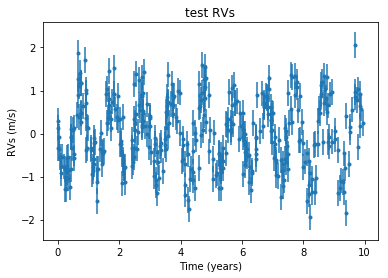

In [3]:
plt.errorbar(t, syn_rv, yerr=errvel, fmt='.')
plt.xlabel("Time (years)")
plt.ylabel("RVs (m/s)")
plt.title("test RVs")
plt.show()

In [4]:
K

0.894309210764695

Creating radvel model
====================================

In [5]:
# radvel paper https://arxiv.org/abs/1801.01947
# radvel github https://github.com/California-Planet-Search/radvel
import radvel
import corner
import copy
from scipy import optimize
from radvel.plot import orbit_plots

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/radvel/gp.py:33: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  Try installing celerite using 'pip install celerite'", ImportWarning)
numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [6]:
params = radvel.Parameters(1,basis='per tc secosw sesinw k')
params['k1'] = radvel.Parameter(value=K * (1 + 0.1 * rd.randn()))
# params['per1'] = radvel.Parameter(value=Ps[0])
params['per1'] = radvel.Parameter(value=Ps[0] * (1 + 0.1 * rd.randn()))
params['secosw1'] = radvel.Parameter(value=0.01)
params['sesinw1'] = radvel.Parameter(value=0.01)
params['tc1'] = radvel.Parameter(value=0.)
rv_mod = radvel.RVModel(params)
rv_mod

Generate likelihood
====================================

In [7]:
# t *= days_p_year  # radvel uses days
like_syn = radvel.likelihood.RVLikelihood(rv_mod, t, syn_rv, np.zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=jitter)

like_syn.params['jit'].vary = False # Don't vary jitter
# like_syn.params['per1'].vary = False # Don't vary period

Get MLE just using data
====================================

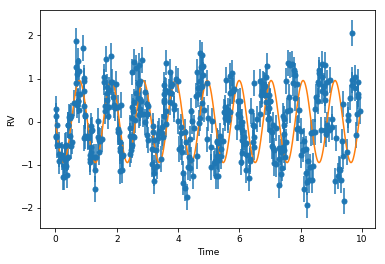

In [8]:
# Plot initial model
plot_results(like_syn) 

parameter                     value      vary
per1                       0.997097       True
tc1                        0.010704       True
secosw1                   0.0193639       True
sesinw1                    0.018865       True
k1                         0.897398       True
dvdt                     0.00258147       True
curv                    -0.00101006       True
gamma                    -0.0157817       True
jit                             0.3      False



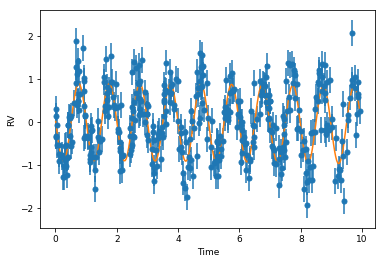

In [9]:
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead')
# res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B')
# print(res)
print(like_syn)
plot_results(like_syn) # plot best fit model

Initialize posterior and add priors
====================================

In [10]:
post = radvel.posterior.Posterior(like_syn)

post.params['per1'] = radvel.Parameter(value=Ps[0] * (1 + 0.1 * rd.randn()))
post.params['k1'] = radvel.Parameter(value=K * (1 + 0.1 * rd.randn()))
post.params['jit'].vary = False
# post.priors += [radvel.prior.EccentricityPrior(1)]
# post.priors += [radvel.prior.EccentricityPrior(1, 0.99)]
# post.priors += [radvel.prior.EccentricityPrior(1, 0.9)]
post.priors += [radvel.prior.EccentricityPrior(1, 0.4)]
post.priors += [radvel.prior.Gaussian('jit', errvel, 0.1)]
post.priors += [radvel.prior.Gaussian('per1', Ps[0], 0.1)]

print("Before fitting\n")
print(post)

Before fitting

parameter                     value      vary
per1                        1.00084       True
tc1                        0.010704       True
secosw1                   0.0193639       True
sesinw1                    0.018865       True
k1                         0.921161       True
dvdt                     0.00258147       True
curv                    -0.00101006       True
gamma                    -0.0157817       True
jit                             0.3      False

Priors
------
e1 constrained to be < 0.4
Gaussian prior on jit, mu=0.3, sigma=0.1
Gaussian prior on per1, mu=1, sigma=0.1



Fit based on priors
====================================

After fitting

parameter                     value      vary
per1                        0.99717       True
tc1                       0.0279434       True
secosw1                   -0.212274       True
sesinw1                    -0.10703       True
k1                         0.906719       True
dvdt                      0.0190322       True
curv                    -0.00286954       True
gamma                     -0.025056       True
jit                             0.3      False

Priors
------
e1 constrained to be < 0.4
Gaussian prior on jit, mu=0.3, sigma=0.1
Gaussian prior on per1, mu=1, sigma=0.1



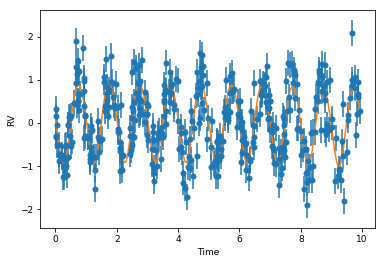

In [11]:
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
plot_results(post.likelihood)
print("After fitting\n")
print(post)

No handles with labels found to put in legend.


(<Figure size 540x555.429 with 4 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f3d36d49588>])

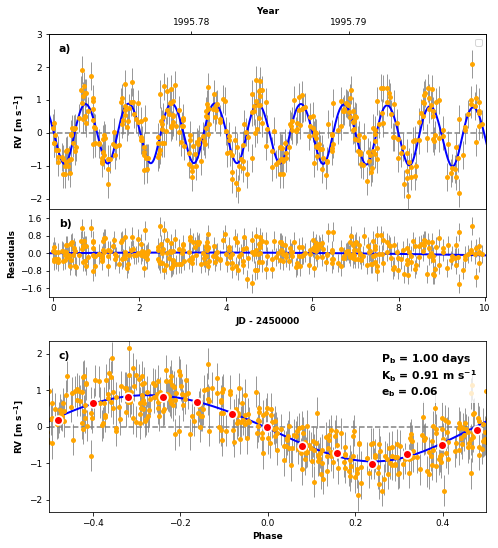

In [12]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()

Use mcmc to sample the posterior distribution and corner to visualize
========================

In [13]:
df = radvel.mcmc(post,nwalkers=20,nrun=1000)

8000/160000 (5.0%) steps complete; Running 12239.85 steps/s; Mean acceptance rate = 47.5%; Min Tz = 1879.1; Max G-R = 1.015      
Discarding burn-in now that the chains are marginally well-mixed

88000/160000 (55.0%) steps complete; Running 8380.00 steps/s; Mean acceptance rate = 42.7%; Min Tz = 6232.5; Max G-R = 1.004       
Chains are well-mixed after 88000 steps! MCMC completed in 8.6 seconds




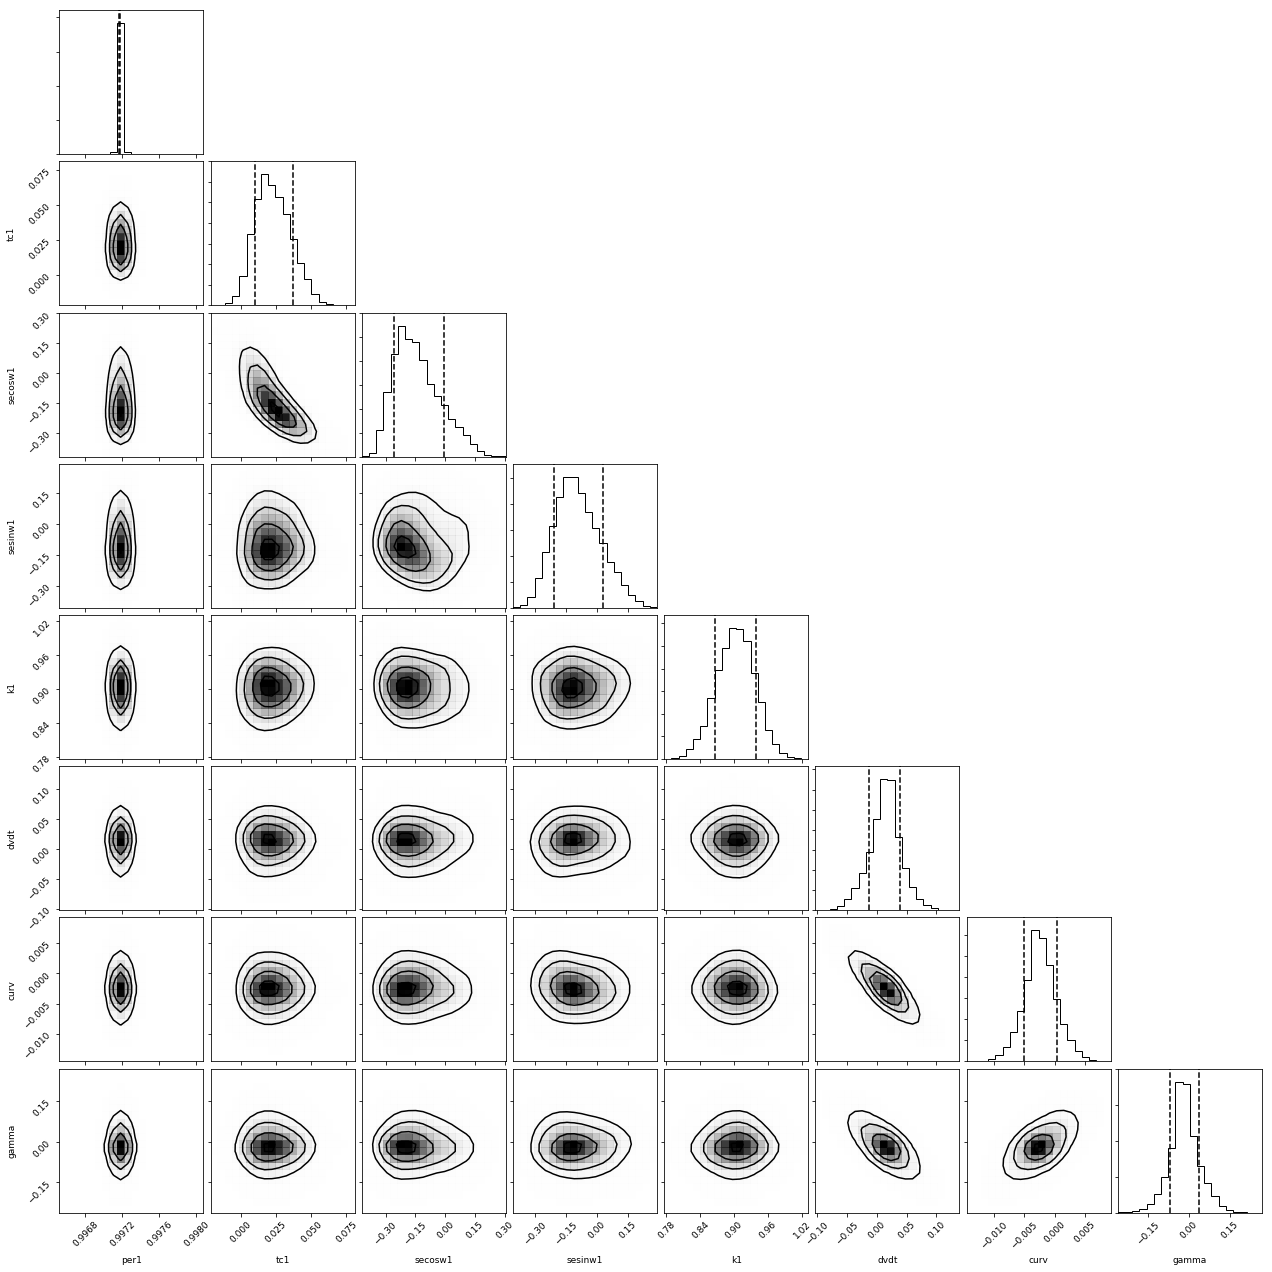

In [14]:
labels = [k for k in post.params.keys() if post.params[k].vary]

# fig = corner.corner(
#     df[labels],
#     labels=labels,
#     truths=[truths[k].value for k in labels ],
#     quantiles=[0.15,0.85],
#     plot_datapoints=False,
#     smooth=True,
#     bins=20
#     )
fig = corner.corner(
    df[labels],
    labels=labels,
    quantiles=[0.15,0.85],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )

In [15]:
hist(df.lnprobability)